In [1]:
import os
while os.path.basename(os.getcwd()) != 'ecological-restoration':
    os.chdir('..')
    print(os.getcwd())

e:\bk\sarth\Github\ecological-restoration\Code\01_Species_Reintroductions
e:\bk\sarth\Github\ecological-restoration\Code
e:\bk\sarth\Github\ecological-restoration


In [2]:
from Species_Reintroductions import *

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import odeint

In [4]:
import gzip
import pickle
import pickletools

def PickleObj(obj, filepath):
    with gzip.open(filepath, "wb") as f:
        pickled = pickle.dumps(obj)
        optimized_pickle = pickletools.optimize(pickled)
        f.write(optimized_pickle)

def UnpickleObj(filepath):
    with gzip.open(filepath, 'rb') as f:
        p = pickle.Unpickler(f)
        obj = p.load()
    return obj

M_Real = UnpickleObj(
    os.path.join(
        os.getcwd(), 'Code', '01_Species_Reintroductions', '01_Simulation_Execution', 'M_Real.pkl'
    )
)
M0 = M_Real['M_PL_041']
print(M0.shape)

(31, 43)


In [5]:
def EOM2D(x, t, M0):
    alpha = 0.3
    h = 0.7
    mu = 1e-4
    gamma0 = 1.0
    p = 0.5
    bii = 1
    #bij = 0.01
    bij = 0
    
    n,m = M0.shape
    D = np.concatenate((np.sum(np.array(M0), axis = 1),np.sum(np.array(M0), axis = 0)), axis = None)
    term1 = mu + x*alpha
    term2 = []
    term3 = []
    for i in range(n):
        temp1 = 0
        temp2 = 0
        for j in range(n):
            if i != j:
                temp1 += bij*x[j]
            elif i == j:
                temp1 += bii*x[j]
        term2.append((-1.0)*temp1*x[i])
        for k in range(m):
            if M0.iloc[i,k]:
                temp2 += (gamma0 / ((D[i])**p))*x[n+k]
        term3.append((temp2 / (1 + h*temp2))*x[i])
    for i in range(m):
        temp1 = 0
        temp2 = 0
        for j in range(m):
            if i != j:
                temp1 += bij*x[n+j]
            elif i == j:
                temp1 += bii*x[n+j]
        term2.append((-1.0)*temp1*x[n+i])
        for k in range(n):
            if M0.iloc[k,i]:
                temp2 += (gamma0 / ((D[i+n])**p))*x[k]
        term3.append((temp2 / (1 + h*temp2))*x[i+n])
    return term1 + np.array(term2) + np.array(term3)

def ODE_Solve(A,t0=0,tf=100,num=50,x_low=10e-3):
    t = np.linspace(t0,tf,num)
    n,m = A.shape
    x0 = np.ones(n+m)*x_low
    xl = odeint(EOM2D,x0,t,args=(A,))
    return xl, xl[:,0:n], xl[:,-m:]

xl, xln, xlm = ODE_Solve(M0)

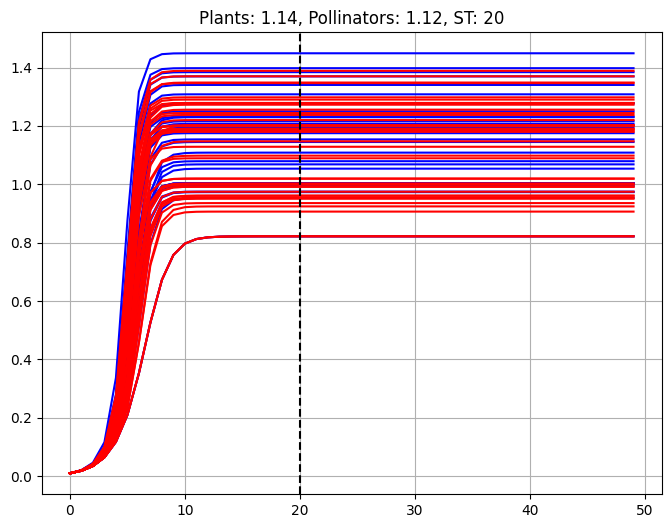

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
pd.DataFrame(xln).plot(color = 'blue', legend = False, ax = ax)
pd.DataFrame(xlm).plot(color = 'red', legend = False, ax = ax)
plt.title(f"Plants: {np.mean(xln[-1,:]):.2f}, Pollinators: {np.mean(xlm[-1,:]):.2f}, ST: {getResilience(xl)}")
plt.axvline(x = getResilience(xl), color = 'black', linestyle = '--')
plt.grid()
plt.show()

In [11]:
def EOM2D_reduced(x, t, g_p, g_a):
    alpha = 0.3
    h = 0.7
    mu = 1e-4
    gamma0 = 1.0
    p = 0.5
    bii = 1
    #bij = 0.01
    bij = 0
    kappa = 0

    Pe, Ae = x[0], x[1]
    return [alpha*Pe - bii*(Pe**2) + mu + (g_p*Ae*Pe)/(1 + h*g_p*Ae), 
    (alpha-kappa)*Ae - bii*(Ae**2) + mu + (g_a*Pe*Ae)/(1 + h*g_a*Pe)]

def ODE_Solve_reduced(A,t0=0,tf=100,num=50,x_low=10e-3):
    t = np.linspace(t0,tf,num)
    n,m = A.shape
    x0 = np.ones(2)*x_low

    Degree_P = list(np.sum(np.array(A), axis = 1))
    Degree_A = list(np.sum(np.array(A), axis = 0))

    p = 0.5
    gamma0 = 1.0
    g_p = np.sum(gamma0 * np.power(np.array(Degree_P),1-p)) / len(Degree_P)
    g_a = np.sum(gamma0 * np.power(np.array(Degree_A),1-p)) / len(Degree_A)

    xl = odeint(EOM2D_reduced,x0,t,args=(g_p,g_a,))
    return xl

xl_reduced = ODE_Solve_reduced(M0)

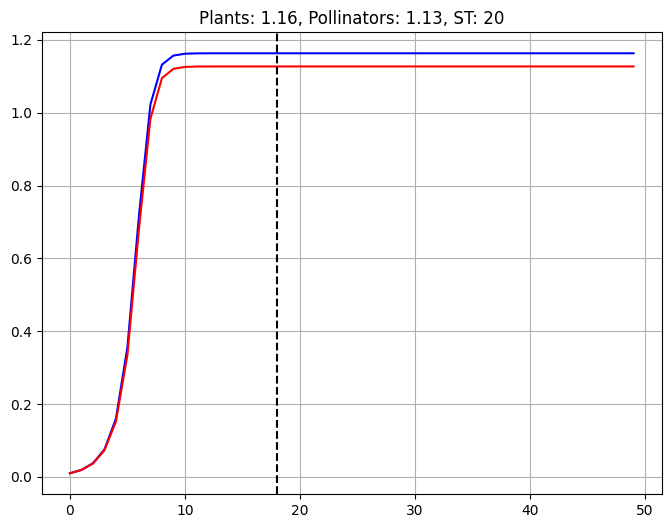

In [12]:
xln_reduced = pd.DataFrame(xl_reduced[:, 0])
xlm_reduced = pd.DataFrame(xl_reduced[:, 1])
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
pd.DataFrame(xln_reduced).plot(color = 'blue', legend = False, ax = ax)
pd.DataFrame(xlm_reduced).plot(color = 'red', legend = False, ax = ax)
plt.title(f"Plants: {xln_reduced.iloc[-1, 0]:.2f}, Pollinators: {xlm_reduced.iloc[-1, 0]:.2f}, ST: {getResilience(xl)}")
plt.axvline(x = getResilience(xl_reduced), color = 'black', linestyle = '--')
plt.grid()
plt.show()
